# Ejercicio de Feedback Regresiones y Random Forest

## Regresión lineal

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
np.set_printoptions(legacy='1.25')


In [14]:
df_casas=pd.read_csv('datasets/precio_casas.csv')

### Apartado 1.1

Calcular la media y la varianza de la variable “size” del dataset. Dibujar este histograma
incluyendo la media y la desviación estándar y realizar una breve interpretación de la
distribución.

In [15]:
df_casas['size'].mean()

97.28

In [16]:
df_casas['size'].var()

1906.6324832214764

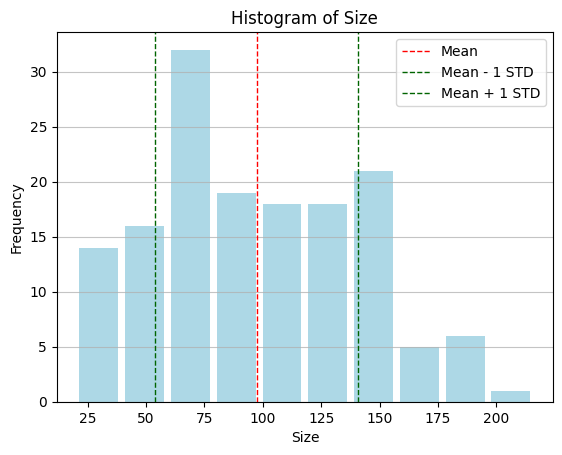

In [17]:
plt.hist(df_casas['size'], bins=10, color='lightblue', rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

plt.axvline(df_casas['size'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')

plt.axvline(df_casas['size'].mean() - df_casas['size'].std(), color='darkgreen', linestyle='dashed', linewidth=1, label='Mean - 1 STD')
plt.axvline(df_casas['size'].mean() + df_casas['size'].std(), color='darkgreen', linestyle='dashed', linewidth=1, label='Mean + 1 STD')

plt.xlabel('Size')
plt.ylabel('Frequency')
plt.title('Histogram of Size')
plt.legend()
plt.show()

Podemos ver como la distribución no es simétrica y tiene un cierto sesgo positivo, ya que los tamaños mas grandes aparecen con menos freciencia. La mayor parte de los valores se concenctran entre los 50 y 150 metros cuadrados, que coinciden con las dos lineas que hemos "pintado" para representar la desviación estándar. Esto hace que la distribución no sea estrictamente normal, pero si podemos decir que la distribucion esta equilibrada.

### Apartado 1.2

Realizar un gráfico de dispersión (scatter plot) de la variable size frente a la variable price, y de
la variable location_index frente a la variable price. A priori, en términos de una regresión
lineal simple, ¿cuál de las dos variables elegirías como variable predictora para el desarrollo del
modelo, tomando como variable objetivo la variable price?

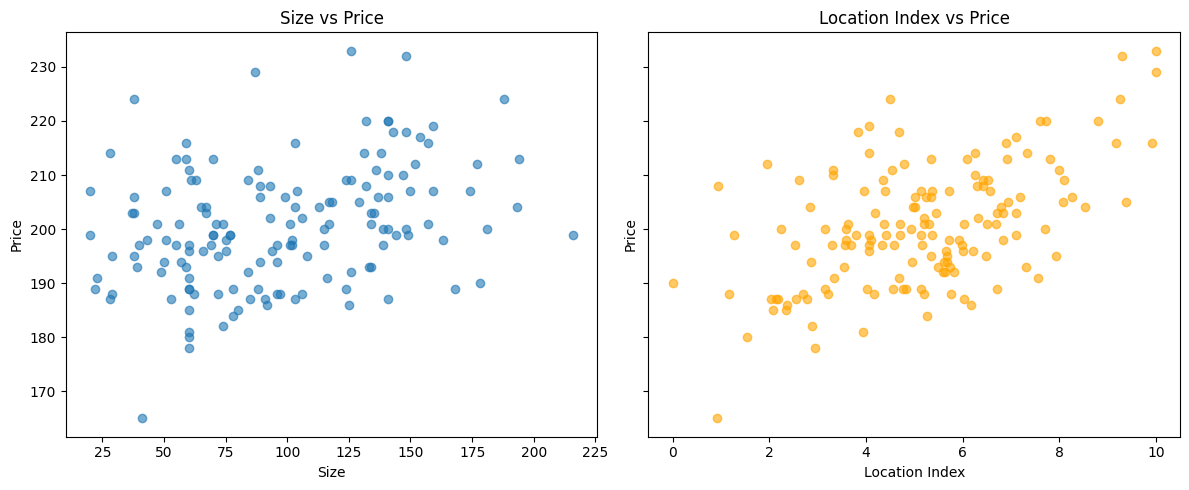

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Scatter plot 1: Size vs Price
axes[0].scatter(df_casas['size'], df_casas['price'], alpha=0.6)
axes[0].set_title('Size vs Price')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Price')

# Scatter plot 2: Location Index vs Price
axes[1].scatter(df_casas['location_index'], df_casas['price'], alpha=0.6, color='orange')
axes[1].set_title('Location Index vs Price')
axes[1].set_xlabel('Location Index')
axes[1].set_ylabel('Price')
plt.tight_layout()
plt.show()

Viendo las gráficas, en términos de regresión lineal simple, elegiría la variable size como la variable predictora para el desarrollo del modelo. La razón principal es que existe una relación ligeramente más clara y lineal entre size y price en comparación con location_index y price.

### Apartado 1.3


Desarrolla un modelo de regresión lineal con la variable location_index, tomando un 80% del conjunto inicial como conjunto de entrenamiento y “135” como semilla en la división de conjunto de entrenamiento y test. Evalúa los supuestos del modelo. ¿Qué ocurre con el Test Reset de Ramsey? ¿Qué consecuencias en este caso puede tener el resultado del Test Reset de Ramsey en nuestro modelo?

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_casas['location_index'].values, df_casas['price'].values.reshape(-1,1), test_size=0.2, random_state=135)

In [20]:
model_single = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model_single.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     52.61
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           4.63e-11
Time:                        11:01:53   Log-Likelihood:                -436.86
No. Observations:                 120   AIC:                             877.7
Df Residuals:                     118   BIC:                             883.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.1266      2.420     76.074      0.000     179.334     188.919
x1             3.1515      0.434      7.253      0.000       2.291       4.012
==============================================================================
Omnibus:                        1.900   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.753
Skew:                           0.192   Prob(JB):                        0.416
Kurtosis:                       2.550   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

En los supuestos del modelo valoraremos lo siguiente:
- Linealidad usando el Test RESET de Ramsey
- Homocedasticidad usando el Test de Breusch-Pagan
- Normalidad usando el Test de Shapiro-Wilk
- Independencia usando el Test de Durbin-Watson

In [21]:
def linear_regression_assumptions(model):
    # Linealidad mediante el test RESET de Ramsey
    p_valor_reset = linear_reset(model).pvalue
    print(f"P-valor del test RESET de Ramsey: {p_valor_reset}")
    # Homocedadasticidad mediante el test de Breusch-Pagan
    p_valor_breuschpagan = het_breuschpagan(model.resid, model.model.exog)[1]
    print(f"P-valor del test de Breusch-Pagan: {p_valor_breuschpagan}")
    # Normalidad de los residuos mediante el test de Shapiro-Wilk
    p_valor_shapiro = shapiro(model.resid)[1]
    print(f"P-valor del test de Shapiro-Wilk: {p_valor_shapiro}")
    #Independencia de los residuos mediante el test de Durbin-Watson
    d_w = durbin_watson(model.resid)
    print(f"Estadístico de Durbin-Watson: {d_w}")

In [22]:
def linear_regression_model_evaluation(model, X_test, y_test):
    y_pred = model.predict(sm.add_constant(X_test))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")

In [23]:
linear_regression_assumptions(model_single)

P-valor del test RESET de Ramsey: 0.005220037289301747
P-valor del test de Breusch-Pagan: 0.591593291847076
P-valor del test de Shapiro-Wilk: 0.4703813608465489
Estadístico de Durbin-Watson: 1.8102373919411723


In [24]:
linear_regression_model_evaluation(model_single, X_test, y_test)

MAE: 7.3260008253526125
MSE: 99.32136384535714
R2: 0.20180350337246133


Debido al resultado de el test RESET de Ramsey: El p-valor obtenido es muy bajo, por lo que podemos decir que el modelo lineal simple no es suficiente para explicar la variable objetivo, llevando a que el modelo nos de predicciones inexactas.


### Apartado 1.4

Tomando como variables de entrada todas las variables menos la variable objetivo, desarrolla un modelo de regresión lineal múltiple, de nuevo fijando los parámetros de división de entrenamiento y prueba del apartado anterior. Evalúa los supuestos del modelo e interpreta brevemente los resultados. Calcula el $R^2$ del modelo. ¿Crees que es un valor de calidad confiable?

In [25]:
X = df_casas.drop(columns=['price']).values
y = df_casas['price'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=135)

In [26]:
model_multiple = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model_multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     181.1
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           1.35e-43
Time:                        11:01:53   Log-Likelihood:                -354.74
No. Observations:                 120   AIC:                             717.5
Df Residuals:                     116   BIC:                             728.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        130.5439      3.204     40.745      0.000     124.198     136.890
x1             0.1070      0.010     10.734      0.000       0.087       0.127
x2             3.6767      0.224     16.419      0.000       3.233       4.120
x3            13.3753      0.867     15.420      0.000      11.657      15.093
==============================================================================
Omnibus:                        1.608   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                1.403
Skew:                          -0.115   Prob(JB):                        0.496
Kurtosis:                       2.523   Cond. No.                         806.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
linear_regression_assumptions(model_multiple)

P-valor del test RESET de Ramsey: 0.659243507849119
P-valor del test de Breusch-Pagan: 0.5005729691871394
P-valor del test de Shapiro-Wilk: 0.5065491211246348
Estadístico de Durbin-Watson: 1.748509552402457


In [28]:
linear_regression_model_evaluation(model_multiple, X_test, y_test)

MAE: 2.8150049704790954
MSE: 12.957098082783164
R2: 0.8958702348042679


Interpretación de los supuestos de la regresión lineal
- Linealidad usando el Test RESET de Ramsey: Hemos un p-valor de 0.66, que nos indica que podemos aceptar la hipótesis nula y que podemos aceptar que existe una relación lineal entre las variables predictoras y objetivo.
- Homocedasticidad usando el Test de Breusch-Pagan: Hemos obtenido un p-valor de 0.5, con el que tambien decir que los residuos son homocedásticos.
- Normalidad usando el Test de Shapiro-Wilk: Hemos obtenido un p-valor de 0.5, con lo que podemos decir que los residuos están distribuidos de manera normal
- Independencia usando el Test de Durbin-Watson: El p-valor nos ha dado 1.74. En este test, los valores van de 0 a 4, y en este caso nos ha dado un valor cercano a 2 lo que nos indica que los residuos son suficientemente independientes entre si.

**Conclusión:** Podemos decir que el modelo cumple con los cuatro supuestos de la regresión lineal.

Interpretación de los resultados de la evaluación del modelo de regresión
- Error absoluto medio (MAE): De media, los resultados se desvian 2.82 del valor real de la variable price.
- Error cuadrático medio (MSE): El error promedio al cuadrado es de 12.95, que es relativamente bajo.
- $R^2$: El valor nos indica que el modelo predice el 89.6% de la variabilidad del precio, lo que nos sugiere un ajuste muy bueno.

**Conclusión:** Las métricas de evalucación nos dice que el error es bajo y tenemos un buen ajuste

## Regresión Logística

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import roc_curve, auc

In [30]:
df_cancer=pd.read_csv('datasets/deteccion_cancer.csv')

### Apartado 2.1

¿Cuál es la probabilidad de que extrayendo una observación del dataset ocurra que tomemos un nevus maligno? ¿Cuál es el odd asociado a este suceso (extraer una observación donde el nevus es maligno)? ¿Y el log-odd? (Recuerda que para calcular el logaritmo neperiano de un valor en Python utilizamos la función np.log($x_0$)).

In [31]:
p = df_cancer["Diagnosis"].value_counts()[0] / df_cancer.shape[0]
print(f"Probabilidad de que extraigamos una observación de un paciente tenga cáncer: {p}")

Probabilidad de que extraigamos una observación de un paciente tenga cáncer: 0.6274165202108963


In [32]:
odd = p / (1 - p)
print(f"Odds de que extraigamos una observación de un paciente tenga cáncer: {odd}")

Odds de que extraigamos una observación de un paciente tenga cáncer: 1.6839622641509435


In [33]:
log_odd = np.log(odd)
print(f"Log odds de que extraigamos una observación de un paciente tenga cáncer: {log_odd}")

Log odds de que extraigamos una observación de un paciente tenga cáncer: 0.5211495071076268


### Apartado 2.2

Calcula 3 regresiones logísticas simples utilizando las 3 variables predictoras de la tabla (tomando como variable objetivo Diagnosis), formulando en los 3 casos un conjunto de test que suponga el 25% de las observaciones totales con la semilla “135”. En un supuesto de regresión logística simple, basado en la métrica gini, ¿qué variable predice mejor el cáncer?

In [34]:
y = df_cancer["Diagnosis"]
X = df_cancer.drop(columns=["Diagnosis"])
models_log_simple = {}
for column in X.columns:
    print(f"Variable predictora: {column}")
    X_train, X_test, y_train, y_test = train_test_split(X[column].values.reshape(-1,1), y, test_size=0.2, random_state=135)
    models_log_simple[column] = LogisticRegression().fit(X_train, y_train)
    y_prob = models_log_simple[column].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds= roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc-1
    print(f"    Gini: {gini}")



Variable predictora: radius
    Gini: 0.9106317411402158
Variable predictora: texture
    Gini: 0.555315870570108
Variable predictora: concavity
    Gini: 0.899537750385208


La variable `radius` predice mejor el cáncer ya que tiene el mayor gini de los tres modelos

### Apartado 2.3

Realiza una regresión logística múltiple utilizando las 3 variables en un mismo modelo, tomando como parámetros de la regresión logísticas los mismos que en el apartado anterior. Dibuja la curva ROC. Indica la ganancia o pérdida de gini de la regresión logística múltiple con respecto a los tres modelos desarrollados en el apartado anterior .

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=135)
model_log_multiple = LogisticRegression().fit(X_train, y_train)

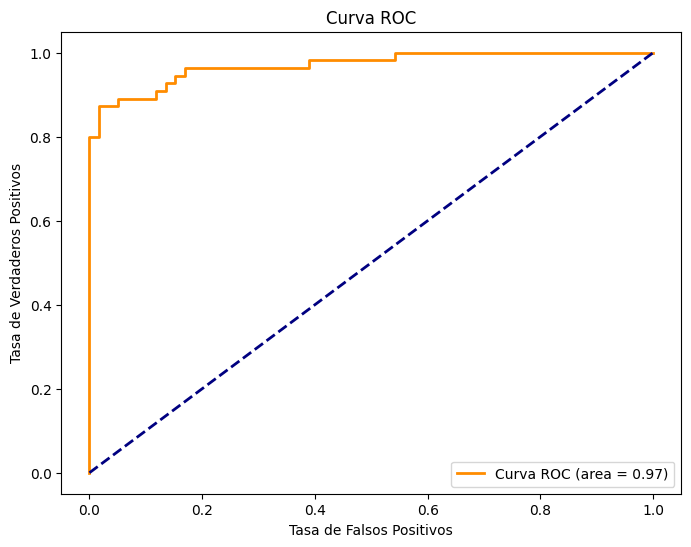

In [36]:
y_prob = model_log_multiple.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
gini = 2*roc_auc-1
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Con respecto al caso anterior en el que hicimos tres modelos de regresión logística distintos para cada columna del dataset, podemos ver como el coeficiente de gini a aumentado de un 0.91 (en el mejor de los casos, es decir, la columna `radius`) a un 0.97, y por tanto podemos decir que el la capacidad de clasificiacion del modelo de regresión logística múltiple que hemos desarrollado es mejor.

### Apartado 2.4

Si tuvieras que valorar definir un umbral para el modelo desarrollado, ¿en qué métrica te
basarías?

Como en este caso estamos tratando un tema médico, para nosotros lo más importante sería minimizar la tasa de falsos negativos. Para ello, la métrica que mas nos interesaría es el recall o sensibilidad.

## Random Forest

In [37]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

### Apartado 3.1

Entrena un árbol de clasificación, utilizando un conjunto de testeo del 20% (continuando con la semilla “135”), con una profundidad máxima de 7 y un número mínimo de observaciones por split de 10. Obtén sus métricas de precisión, recall y f1-score.

In [38]:
def model_metrics(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=135)

In [40]:
classifiction_tree = DecisionTreeClassifier(max_depth=7, min_samples_split=10).fit(X_train, y_train)
model_metrics(y_test, classifiction_tree.predict(X_test))

Recall: 0.8727272727272727
Precision: 0.9411764705882353
F1: 0.9056603773584906


### Apartado 3.2

Entrena un Random Forest con 100 estimadores y una profundidad máxima de 6, con el mismo
conjunto de entrenamiento y prueba que el apartado anterior . Fija la misma semilla en el
desarrollo del modelo (“135”). Dibuja su curva ROC asociada. Obtén sus métricas de precisión,
recall y f1-score. Haz una comparativa con los resultados del modelo de árbol de clasificación
del apartado anterior . ¿Qué modelo predice mejor de todos los desarrollados en los dos
últimos apartados? ¿Cuál crees que pueden ser las causas de que dicho modelo tenga un mejor
rendimiento?

In [41]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=135).fit(X_train, y_train).fit(X_train, y_train)

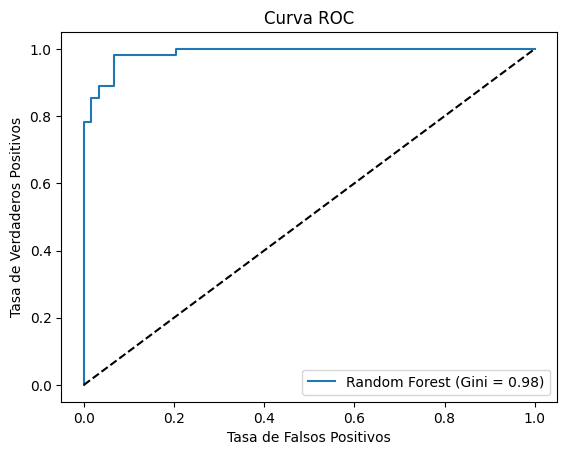

In [42]:
y_proba = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (Gini = {:.2f})".format(2*roc_auc_score(y_test, y_proba)-1))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [43]:
model_metrics(y_test, random_forest.predict(X_test))

Recall: 0.8909090909090909
Precision: 0.9607843137254902
F1: 0.9245283018867925


#### Comparativa de modelos

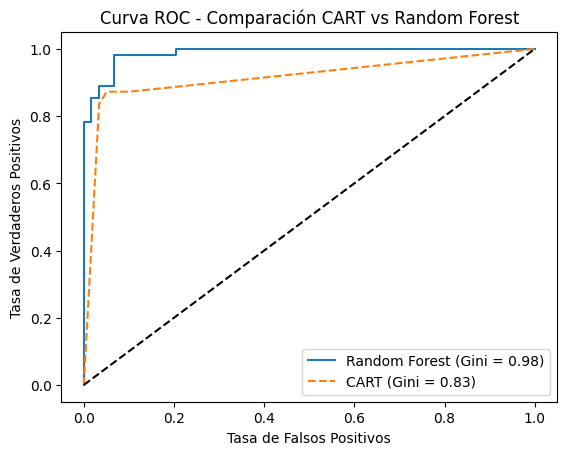

In [44]:
y_proba_tree = classifiction_tree.predict_proba(X_test)[:, 1]
y_proba_rf = random_forest.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (Gini = {:.2f})".format(2*roc_auc_score(y_test, y_proba_rf)-1))
plt.plot(fpr_tree, tpr_tree, label="CART (Gini = {:.2f})".format(2*roc_auc_score(y_test, y_proba_tree)-1), linestyle="--")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Comparación CART vs Random Forest")
plt.legend(loc="lower right")
plt.show()

In [45]:
print("CART")
model_metrics(y_test, classifiction_tree.predict(X_test))
print("\n")
print("Random Forest")
model_metrics(y_test, random_forest.predict(X_test))

CART
Recall: 0.8727272727272727
Precision: 0.9411764705882353
F1: 0.9056603773584906


Random Forest
Recall: 0.8909090909090909
Precision: 0.9607843137254902
F1: 0.9245283018867925


**Conlcusión:** Aunque la diferencia no es muy grande, podemos ver que el random forest nos ha dado mejores métricas de evaluación que el árbol de clasificación. Esto se debe a que  combina la robustez de múltiples árboles individuales, introduce aleatoriedad para diversificar las decisiones y utiliza la agregación para suavizar el ruido y mejorar la generalización. Esto lo hace ideal para manejar conjuntos de datos grandes, complejos y ruidosos, superando las limitaciones de un único árbol clasificación.